In [ ]:
from langgraph.graph import StateGraph, START , END
from typing import TypedDict, Annotated , List
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langgraph.types import interrupt, Command
from dotenv import load_dotenv
import requests
from pathlib import Path
import operator
from pydantic import BaseModel, Field
from typing import Literal
from langchain_mistralai import ChatMistralAI
from langgraph.types import Send
import re
import os

key = "Your Api key here"

model = ChatMistralAI(
    model="mistral-large-2512",
    mistral_api_key= key,  # Direct key
    temperature=0.7
)

In [3]:
class Task(BaseModel):
    id : int 
    title : str 
    brief : str = Field(..., description= " What to cover")

In [4]:
class Plan(BaseModel):
    blog_title : str 
    tasks : List[Task]

In [5]:
class State(TypedDict):
    topic : str 
    plan : Plan 
    #reducer : results from workers can get connected automatically 
    Section : Annotated[List[str], operator.add]
    final_blog : str 

In [6]:
def orchestrator(State : State):
    llm_with_structure_output = model.with_structured_output(Plan)
    plan = llm_with_structure_output.invoke([
        SystemMessage(content="Create blog with 5-7 sections on the following topic"),
        HumanMessage(content= f"Topic : {State["topic"]}")
    ])

    return {"plan" : plan}



In [7]:
def condition_toget_workers(State : State):
    return [Send("worker", {"task": task, "topic" : State["topic"], "plan": State["plan"]}) for task in State["plan"].tasks]

In [23]:
def worker(payload : dict) -> dict:
    task = payload["task"]
    topic = payload["topic"]
    plan = payload["plan"]
    blog_title = plan.blog_title

    section = [SystemMessage(content="Write one clean markdown section"),
               HumanMessage(content = 
                            f"""Blog : {blog_title}\n
                            topic : {topic}\n\ng
                            Section : {task.title}\n
                            Breif : {task.brief}
                            Return only the section content in Markdown""")]
    response = model.invoke(section).content.strip()
    return {"Section" : [response]}

In [24]:
def reducer(State: State) -> dict:
    
    title = State["plan"].blog_title
    body = "\n\n".join(State["Section"]).strip()

    final_md = f"# {title}\n\n{body}\n"

    # ---- save to file ----
    filename = "research_paper.md"
    output_path = Path(filename)
    output_path.write_text(final_md, encoding="utf-8")

    return {"final_blog": final_md}

In [25]:
graph = StateGraph(State)

In [26]:
graph.add_node("orchestrator", orchestrator)
graph.add_node("worker",worker)
graph.add_node("reducer",reducer)

graph.add_edge(START,"orchestrator")
graph.add_conditional_edges("orchestrator", condition_toget_workers, ["worker"])
graph.add_edge("worker","reducer")
graph.add_edge("reducer",END)

workflow = graph.compile()

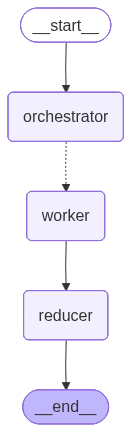

In [27]:
workflow

In [28]:
result = workflow.invoke({"topic": "Trustworthy Agentic AI Systems: A Cross-Layer Review of Architectures, Threat Models, and Governance Strategies","Section": []})

In [14]:
result["plan"]

Plan(blog_title='Trustworthy Agentic AI Systems: A Cross-Layer Review of Architectures, Threat Models, and Governance Strategies', tasks=[Task(id=1, title='Introduction to Agentic AI Systems', brief='Define what agentic AI systems are, their significance in modern technology, and why trustworthiness is a critical concern. Highlight real-world applications like autonomous vehicles, healthcare, and finance.'), Task(id=2, title='Architectural Layers of Agentic AI Systems', brief='Explore the cross-layer architecture of agentic AI systems, including perception, decision-making, action, and feedback layers. Discuss how these layers interact and their role in ensuring system reliability.'), Task(id=3, title='Threat Models in Agentic AI Systems', brief='Analyze potential threats to agentic AI systems, such as adversarial attacks, data poisoning, model inversion, and ethical risks. Provide examples of how these threats manifest in real-world scenarios.'), Task(id=4, title='Ensuring Trustworthi

In [15]:
result

{'topic': 'Trustworthy Agentic AI Systems: A Cross-Layer Review of Architectures, Threat Models, and Governance Strategies',
 'plan': Plan(blog_title='Trustworthy Agentic AI Systems: A Cross-Layer Review of Architectures, Threat Models, and Governance Strategies', tasks=[Task(id=1, title='Introduction to Agentic AI Systems', brief='Define what agentic AI systems are, their significance in modern technology, and why trustworthiness is a critical concern. Highlight real-world applications like autonomous vehicles, healthcare, and finance.'), Task(id=2, title='Architectural Layers of Agentic AI Systems', brief='Explore the cross-layer architecture of agentic AI systems, including perception, decision-making, action, and feedback layers. Discuss how these layers interact and their role in ensuring system reliability.'), Task(id=3, title='Threat Models in Agentic AI Systems', brief='Analyze potential threats to agentic AI systems, such as adversarial attacks, data poisoning, model inversion